# Libraries

In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import statistics as stats
import numpy as np
import seaborn as sb

from surprise import Dataset
from surprise import Reader
from surprise import KNNWithMeans
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from datetime import timedelta, date, datetime

## Our Research Details

### &nbsp;&nbsp;&nbsp;&nbsp;Pure exploration and analysis of data in order to see its potential

### &nbsp;&nbsp;&nbsp;&nbsp;User clusterning, as the easiest target of interest for businesses

### &nbsp;&nbsp;&nbsp;&nbsp;Building product (dish) recommendation system, the most usefull oportunity as seen by us

# Data analysis

First, let's find out what our data actually contains.

In [2]:
data = pd.read_csv("Local/mfp-diaries.tsv", sep='\t', header=None, names=["user_id", "diary_date", "food_list", "daily_intake_and_goal"])

### Observation

In [3]:
data.head()

,user_id,diary_date,food_list,daily_intake_and_goal
0,1,2014-09-14,"[{""meal"": ""MY food"", ""dishes"": [{""nutritions"":...","{""total"": [{""name"": ""Calories"", ""value"": 2924}..."
1,1,2014-09-15,"[{""meal"": ""MY food"", ""dishes"": [{""nutritions"":...","{""total"": [{""name"": ""Calories"", ""value"": 2430}..."
2,1,2014-09-16,"[{""meal"": ""MY food"", ""dishes"": [{""nutritions"":...","{""total"": [{""name"": ""Calories"", ""value"": 1862}..."
3,1,2014-09-17,"[{""meal"": ""MY food"", ""dishes"": [{""nutritions"":...","{""total"": [{""name"": ""Calories"", ""value"": 2251}..."
4,1,2014-09-18,"[{""meal"": ""MY food"", ""dishes"": [{""nutritions"":...","{""total"": [{""name"": ""Calories"", ""value"": 2001}..."


In [4]:
print(data['user_id'].dtype)
print(data['diary_date'].dtype)
print(data['food_list'].dtype)
print(data['daily_intake_and_goal'].dtype)

int64
object
object
object


We can see that our data has 4 columns.  
First is user_id: user identifier - integer.  
Second is diary_date: entry date of information - string (object in Pandas’ world is string (text)).  
Third is food_list: For each entry it has meal name and its content (dishes with its nutrients and calories) - string.  
Fourth is daily_intake_and_goal: user's real intake and goal calories and nutrients.

Number of data's entries and features

In [5]:
data.shape

(587187, 4)

Quickly checking if there are some duplicated rows in our data, because we don't need excessive information

In [6]:
print(f"Duplicated rows: {data.duplicated().sum()}")

Duplicated rows: 0


There are none.  
Now we check if there are any missing values in our data, later on it may cause problems (For example, if we decide to use K-means clustering; it can't handle missing values).

In [7]:
print(f"Missing values in each variable: \n{data.isnull().sum()}")

Missing values in each variable: 
user_id                  0
diary_date               0
food_list                0
daily_intake_and_goal    0
dtype: int64


Fortunatelly, no missing values are in our data.

Our data spans following time range:

In [8]:
start_date = data[data.columns[1]].unique().min()
final_date = data[data.columns[1]].unique().max()
print("Start Date: ", start_date)
print("Final Date: ", final_date)

Start Date:  2014-09-14
Final Date:  2015-04-09


It seems like nearly 590k input was submitted in less than a year.  
Now let's see how many distinct dates we have, it should be important later on to consider how consistent users actually were while submitting their data.


In [9]:
print("Distinct Dates: ", len(data[data.columns[1]].unique()))

Distinct Dates:  208


It turns out that there are no duplicated dates, because 208 is literally number of days between Start and Final Dates.  
However, it's interesting to know, if users were equally excited to submit their data during these 208 days, let's find out:

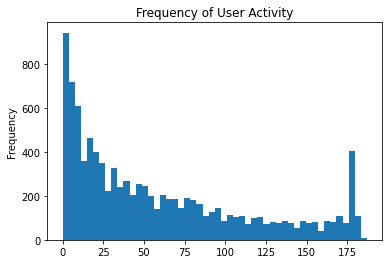

In [10]:
start = datetime.strptime(str(start_date),'%Y-%m-%d').date()
final = datetime.strptime(str(final_date),'%Y-%m-%d').date()
activity = np.zeros(data[data.columns[0]].unique().max())
for i in range(int((final - start).days) + 1):
    curr_date = start + timedelta(i)
    curr_date_string = curr_date.strftime('%Y-%m-%d')
    curr_date = data[data[data.columns[1]] == curr_date_string]
    for j in range(curr_date.shape[0]):
        activity[curr_date.iloc[j,0]-1]+=1

plt.hist(activity, bins=50)
plt.ylabel('Frequency')
plt.title('Frequency of User Activity')
plt.show()

As we can see, at the begining of data entry user activity is quite high, but as time passes activity continues to drop exponentially.  
We also see, that at some point towards the end, activity grows again for a blink. This may be related to the app's popularity in general (for example, let's suppose that loyal users were submmiting data all along, but when this application was advertised some other random poeple also got interested, but their activity was not consistent).

In particular, at some point, very popular sports brand "Under Armour" actively started buying sports apps and in feburary 4th of 2015 it also acquired MyFitnessPal, the app behind the data we're handling. This is consistent with the growth in the graph above, though it seems like this popularity didn't last long for MyFitnessPal. Right now Under Armour is selling MyFitnessPal for 130 million dollars less than it initialy bought it.

Now, let's quickly observe actual food input and its content for our deep understanding and flexibility. As we noted, every food input has its content.

In [11]:
food_entries = json.loads(data.iloc[0, 2])
print(food_entries)

[{'meal': 'MY food', 'dishes': [{'nutritions': [{'name': 'Calories', 'value': '412'}, {'name': 'Carbs', 'value': '29'}, {'name': 'Fat', 'value': '24'}, {'name': 'Protein', 'value': '21'}, {'name': 'Sodium', 'value': '258'}, {'name': 'Sugar', 'value': '29'}], 'name': 'my - McDonalds Espresso Pronto® Flat White, 2 TALL'}, {'nutritions': [{'name': 'Calories', 'value': '170'}, {'name': 'Carbs', 'value': '25'}, {'name': 'Fat', 'value': '5'}, {'name': 'Protein', 'value': '20'}, {'name': 'Sodium', 'value': '260'}, {'name': 'Sugar', 'value': '2'}], 'name': 'Quest Bar - Banana Nut Muffin Natural Protein Bar, 60 g'}, {'nutritions': [{'name': 'Calories', 'value': '176'}, {'name': 'Carbs', 'value': '33'}, {'name': 'Fat', 'value': '1'}, {'name': 'Protein', 'value': '5'}, {'name': 'Sodium', 'value': '195'}, {'name': 'Sugar', 'value': '0'}], 'name': 'Uncle Tobys Australia - Vita Brits, 3 Biscuits 33.3g'}, {'nutritions': [{'name': 'Calories', 'value': '342'}, {'name': 'Carbs', 'value': '34'}, {'name':

It comes clear how each input has information about its energetic value plus nutrients, which itself has array of names and corresponding values. Let's find out how many distinct "nutrients" there are in our data:

In [12]:
distinct_nutritions = {}
for i in range(data.shape[0]):
    food_input = json.loads(data.iloc[i,2])
    for j in range(len(food_input)):
        dishes = food_input[j]['dishes']
        for dish in range(len(dishes)):
            nutritions = dishes[dish]['nutritions']
            for nutrient in range(len(nutritions)):
                nutrient_name = nutritions[nutrient]['name']
                if nutrient_name in distinct_nutritions.keys():  # if already encountered
                    distinct_nutritions[nutrient_name] += 1
                else:
                    distinct_nutritions[nutrient_name] = 1
                    
print(distinct_nutritions.keys())
number_of_distinct_nutrients = len(distinct_nutritions.keys())
print("Number of Distinct Nutrients in our data: " + str(number_of_distinct_nutrients))

dict_keys(['Calories', 'Carbs', 'Fat', 'Protein', 'Sodium', 'Sugar', 'Fiber', 'Potass.', 'Iron', 'Calcium', 'Sat Fat', 'Chol', 'Vit A', 'Vit C', 'Trn Fat', 'Mon Fat', 'Ply Fat'])
Number of Distinct Nutrients in our data: 17


It turns out that we have 17 unique nutrient inputs. Let's see their distribution:

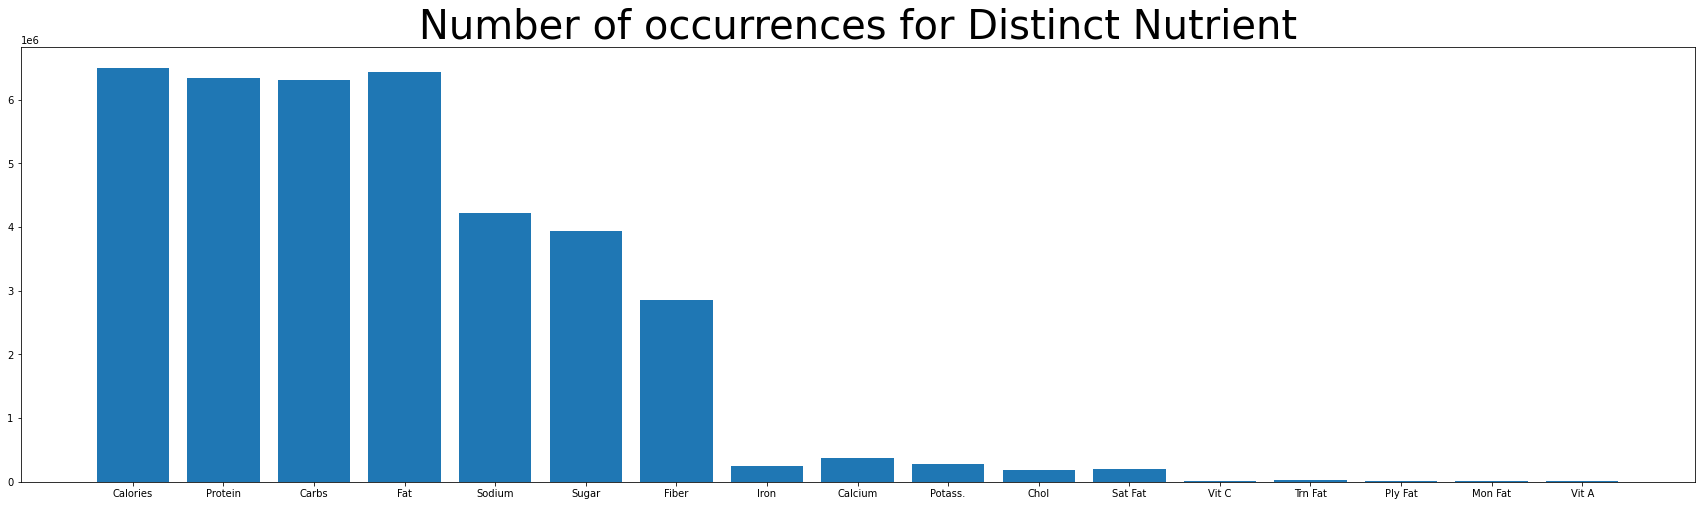

In [13]:
nutrients = sorted(distinct_nutritions.items(), key=lambda x : x[1], reverse = True)
keys = {}
for nutrient in nutrients:
    keys[nutrient[0]] = nutrient[1]
plt.figure(figsize = (30,8))
plt.bar(x = keys.keys(), height = distinct_nutritions.values())
plt.title('Number of occurrences for Distinct Nutrient', size=40)
plt.show()

The most frequently stored item is calories, the most frequent nutrients are obviously macronutrients: protein, carbs and fat.  
Somewhat popular are Sodium, sugar and fiber.  
Rest of the nutrients are pretty rare. Let's not consider them for now and see distribution of popular and somewhat popular nutrients.

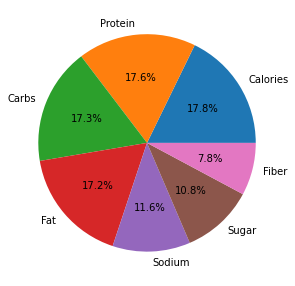

In [14]:
populars = {}
unpopulars =['Vit A', 'Vit C', 'Trn Fat', 'Potass.',
                    'Mon Fat', 'Ply Fat','Iron','Calcium','Chol','Sat Fat']
for nutrient_name in keys.keys():
    if nutrient_name not in unpopulars:
        populars[nutrient_name] = keys[nutrient_name]

plt.figure(figsize=(10,5))
plt.pie(populars.values(), labels = populars.keys(), autopct = "%1.1f%%")
plt.show()

##### Little observations that we don't want to ignore

We explored some random columns (as much as we thought was nearly enough) and found out that some not so consistent, :) users have ruined statistics. For example, there are cases when users don't submit full data: number of their daily meals is one instead of 3 or 4. These users can be considered seperatly and they can have indipendent statistical importance. We may conclude that these kind of users:  
1. are busy and don't have time to enter every meal they eat and use this app every day consistently;  
2. (even sadder) do not eat because of work and busyness or depression;  
Either way we thought these cases were worth noting.

In addition, every food name contains coressponding quantitative description at the end, but it is not consistent unfortunatelly. Our observation showd that some food is described in grams, others in mililiters or cups or number of sticks and so on. We think, this really cuts oportunities for this data as consistent weight information could be of great use.

Data inconsistency makes our task harder, but it's a norm when handling human input data.
It's interesting to note, that app developers have the ability to take future ML analysis into consideration and restrain users to be clear and consistent, but different companies take different approach.

**Sample row for convenience**

In [15]:
user_id = data.iloc[1005,0]
date = data.iloc[1005,1]
food_entries = json.loads(data.iloc[1005, 2])
agregate_intake_goal = json.loads(data.iloc[1005,3])
print(food_entries)

[{'meal': 'Breakfast', 'dishes': [{'nutritions': [{'name': 'Calories', 'value': '90'}, {'name': 'Carbs', 'value': '7'}, {'name': 'Fat', 'value': '1'}, {'name': 'Protein', 'value': '12'}, {'name': 'Sodium', 'value': '75'}, {'name': 'Sugar', 'value': '1'}], 'name': 'Body by Vi - Vi-shape Shake Mix, 2 rounded scoops'}, {'nutritions': [{'name': 'Calories', 'value': '40'}, {'name': 'Carbs', 'value': '2'}, {'name': 'Fat', 'value': '3'}, {'name': 'Protein', 'value': '1'}, {'name': 'Sodium', 'value': '180'}, {'name': 'Sugar', 'value': '0'}], 'name': 'Aldi Friendly Farms - Unsweetened All Natural Vanilla Almond Milk, 8 fl oz'}], 'sequence': 1}, {'meal': 'Lunch', 'dishes': [{'nutritions': [{'name': 'Calories', 'value': '600'}, {'name': 'Carbs', 'value': '25'}, {'name': 'Fat', 'value': '33'}, {'name': 'Protein', 'value': '18'}, {'name': 'Sodium', 'value': '895'}, {'name': 'Sugar', 'value': '4'}], 'name': "Ted's Ct - Steamed Cheeseburger, 1 burger"}], 'sequence': 2}, {'meal': 'Dinner', 'dishes': [

## Data parsing

Let's start actual data parsing.

In [16]:
altered_data = {}

#### Helper functions

Block of code below is responsible for simple initialization of nutrients.

In [17]:
def init_nutrients(user):
    user["calories"] = {}
    user["carbs"] = {}
    user["sugar"] = {}
    user["fat"] = {}
    user["protein"] = {}
    user["goal_calories"] = {}
    user["goal_carbs"] = {}
    user["goal_sugar"] = {}
    user["goal_fat"] = {}
    user["goal_protein"] = {}

Function below adds daily nutrient information to the given user. Also, it's important to point out, that we don't consider an entry valid if there is no information about daily calories in it, because such entry shoulf contain nothing. This is done by returning False instead of True.

In [18]:
def add_nutrients(user, agregate_intake_goal, date):
    calories_filled = False
    goal_calories_filled = False
    for i in range(len(agregate_intake_goal["total"])):
        if agregate_intake_goal["total"][i]["name"] == "Calories":
            calories_filled = True
    for i in range(len(agregate_intake_goal["goal"])):
            if agregate_intake_goal["goal"][i]["name"] == "Calories":
                goal_calories_filled = True

    if calories_filled and goal_calories_filled:
        for i in range(len(agregate_intake_goal["total"])):
            if agregate_intake_goal["total"][i]["name"] == "Calories":
                user["calories"][date] = agregate_intake_goal["total"][i]["value"]
            if agregate_intake_goal["total"][i]["name"] == "Carbs":
                user["carbs"][date] = agregate_intake_goal["total"][i]["value"]
            if agregate_intake_goal["total"][i]["name"] == "Sugar":
                user["sugar"][date] = agregate_intake_goal["total"][i]["value"]
            if agregate_intake_goal["total"][i]["name"] == "Fat":
                user["fat"][date] = agregate_intake_goal["total"][i]["value"]
            if agregate_intake_goal["total"][i]["name"] == "Protein":
                user["protein"][date] = agregate_intake_goal["total"][i]["value"]

        for i in range(len(agregate_intake_goal["goal"])):
            if agregate_intake_goal["goal"][i]["name"] == "Calories":
                user["goal_calories"][date] = agregate_intake_goal["goal"][i]["value"]
            if agregate_intake_goal["goal"][i]["name"] == "Carbs":
                user["goal_carbs"][date] = agregate_intake_goal["goal"][i]["value"]
            if agregate_intake_goal["goal"][i]["name"] == "Sugar":
                user["goal_sugar"][date] = agregate_intake_goal["goal"][i]["value"]
            if agregate_intake_goal["goal"][i]["name"] == "Fat":
                user["goal_fat"][date] = agregate_intake_goal["goal"][i]["value"]
            if agregate_intake_goal["goal"][i]["name"] == "Protein":
                user["goal_protein"][date] = agregate_intake_goal["goal"][i]["value"]
        return True
    else:
        return False

Adds daily calories to the given month.

In [19]:
def add_calories_to_month(month, agregate_intake_goal, user):
    for i in range(len(agregate_intake_goal["total"])):
        if agregate_intake_goal["total"][i]["name"] == "Calories":
            user[month]["calories"] += agregate_intake_goal["total"][i]["value"]
    user[month]["days"] += 1

Initialization of month dictionary.

In [20]:
def init_month(user, date, month):
    user[month] = {}
    user[month]["date"] = date[5:7] + "/" + date[0:4]
    user[month]["days"] = 0
    user[month]["calories"] = 0

Iteration over the whole data and parsing

In [21]:
for i in range(int(len(data))):
    # read i-th row
    user_id = data.iloc[i,0]
    date = data.iloc[i,1]
    food_entries = json.loads(data.iloc[i, 2])
    agregate_intake_goal = json.loads(data.iloc[i,3])

    if user_id not in altered_data:
        altered_data[user_id] = {}
        altered_data[user_id]["first_entry_date"] = date
        altered_data[user_id]["active_days"] = 0
        altered_data[user_id]["food"] = {}
        altered_data[user_id]["food_count"] = 0
        init_nutrients(altered_data[user_id])
        init_month(altered_data[user_id], date, "first_month")
        init_month(altered_data[user_id], date, "last_month")

    if add_nutrients(altered_data[user_id], agregate_intake_goal, date):
        altered_data[user_id]["last_entry_date"] = date
        altered_data[user_id]["active_days"] += 1
    else:
        continue

    if altered_data[user_id]["first_month"]["date"] == date[5:7] + "/" + date[0:4]:
        add_calories_to_month("first_month", agregate_intake_goal, altered_data[user_id])
    else:
        if altered_data[user_id]["last_month"]["date"] != date[5:7] + "/" + date[0:4]:
            init_month(altered_data[user_id], date, "last_month")
        add_calories_to_month("last_month", agregate_intake_goal, altered_data[user_id])

    for meal in food_entries:
        for dish in meal["dishes"]:
            food_name = dish["name"][0:dish["name"].index(',')]
            if food_name != "Quick Added Calories":
                if food_name not in altered_data[user_id]["food"]:
                    altered_data[user_id]["food"][food_name] = {}
                    altered_data[user_id]["food"][food_name]["count"] = 0  
                    altered_data[user_id]["food"][food_name]["nutrients"] = dish["nutritions"]
                altered_data[user_id]["food"][food_name]["count"] += 1
                altered_data[user_id]["food_count"] += 1

## Sample data visualization

Take sample user for closer look and visualization (user #2 - consistent data, #5 - sugars instead of carbs, #8 - no carbon, no sugar, no fat, #689 - number of calories and goal calories entries do not match). We chose to have sample user for observation purposes. By observing on sample users, it might help us decide what variables to construct for each user later on.

In [22]:
sample_user = altered_data[2]
food = sample_user["food"]

For the given user, sets a new value describing the amount
of days from first data entry to (including) the last one. We considered user's active period based on his first and last input date individually (not based on general first/last in out data). 

In [23]:
def calculate_days(user):
    first_year = int(user["first_entry_date"][:4])
    first_month = int(user["first_entry_date"][5:7])
    first_day = int(user["first_entry_date"][8:])
    last_year = int(user["last_entry_date"][:4])
    last_month = int(user["last_entry_date"][5:7])
    last_day = int(user["last_entry_date"][8:])
    f_date = datetime(first_year, first_month, first_day)
    l_date = datetime(last_year, last_month, last_day)
    delta = l_date - f_date
    user["days"] = delta.days + 1

**User activity: active days from all days since first app usage**

In [24]:
calculate_days(sample_user)
print("User activity", sample_user["active_days"], "/", sample_user["days"])

User activity 60 / 60


Function for sorting food according to it's consumption frequency.

In [25]:
def food_sort(key):
    return -food[key]["count"]
# Total amount of users
print("Total users:", len(altered_data.keys()))

Total users: 9896


Print top ten frequently consumed dishes:

In [26]:
food_list = [key for key in food.keys()]
food_list.sort(key=food_sort)
print("Top ten frequent dishes")
for i in range(10):
    print("\t" + food_list[i])

Top ten frequent dishes
	Nescafe - Decaf Coffee With Skimmed Milk
	Sugars - Granulated (sucrose)
	Warburton's - Wholemeal Bread 800g
	Generic - Wholemeal Bread-One Slice
	Nescafe - Double Choca Mocha Uk
	Quorn - Chicken Style Fillet
	Marmite - Marmite
	Bisto Best - Caramelised Onion Gravy
	Quorn - Nugget
	Walkers - Cheese and Onion Crisp


Formats date vertically so that it can be more compact and easier to read.

In [27]:
def vertical_date(date):
    return date[8:] + '\n' + date[5:7] + '\n' + date[2:4]

Formatter function for pie chart magnitudes:

In [28]:
def filter_value(val):
    if (val < 5):
        return ""
    return '{:.2f}%\n({:.0f})'.format(val, sample_user["food_count"] * val / 100)

Plots given nutrient (or calories) distribution throughout app usage.

In [29]:
def plot_nutrients(nutrient, name):
    f = plt.figure() 
    f.set_figwidth(20)
    f.set_figheight(6)
    plt.plot([vertical_date(key) for key in sample_user[nutrient].keys()], [value for value in sample_user[nutrient].values()], marker='o')
    plt.plot([vertical_date(key) for key in sample_user["goal_" + nutrient].keys()], [value for value in sample_user["goal_" + nutrient].values()], marker='o')
    plt.title("Taken " + nutrient + " vs goal " + nutrient)
    plt.xlabel("Days")
    plt.ylabel(name)
    plt.legend(["Taken", "Goal"])
    plt.show()

Label creation for food pie chart:

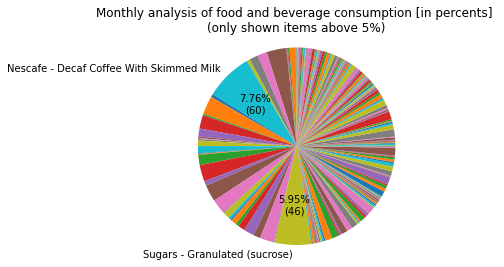

In [30]:
labels = []
for key in food.keys():
    if food[key]["count"] / sample_user["food_count"] < 0.05:
        labels.append("")
    else:
        labels.append(key)

magnitudes = [food[key]["count"] for key in food.keys()]
# Food frequency consumption pie chart
fig1, ax1 = plt.subplots()
ax1.pie(magnitudes, labels=labels, autopct=filter_value, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Monthly analysis of food and beverage consumption [in percents] \n(only shown items above 5%)")
plt.show()

The reason why this pie chart is so chaotic is that the user's choice of dishes is diverse, but it still likes to frequently drink cofee with skimmed milk and sugar.

**Nutrient and calories distribution plots**

Average calories per day: 1457.1666666666667


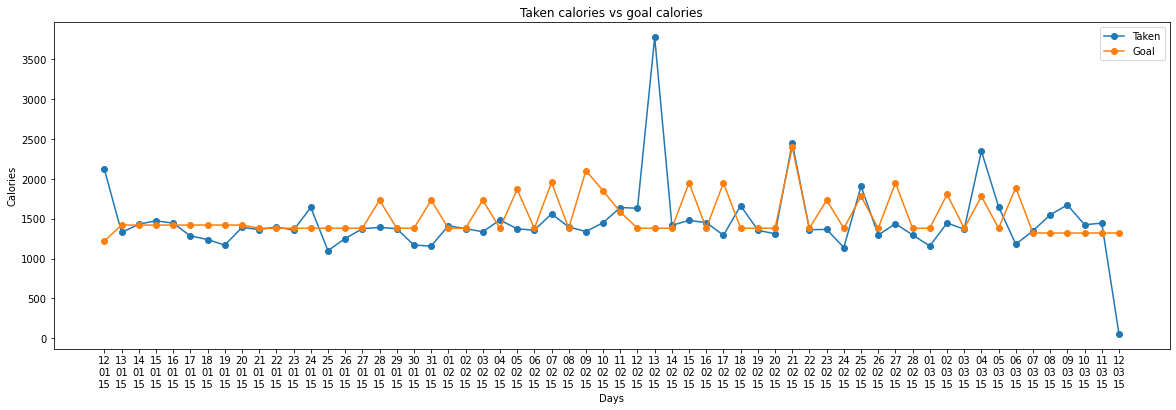

In [31]:
print("Average calories per day:", stats.mean(sample_user["calories"].values()))
plot_nutrients("calories", "Calories")

We think that this is a good opportunity for visualization because for naked eye it's very easy to see user's goal compared to his/her actual taken calories.

Average carbs per day: 181.2


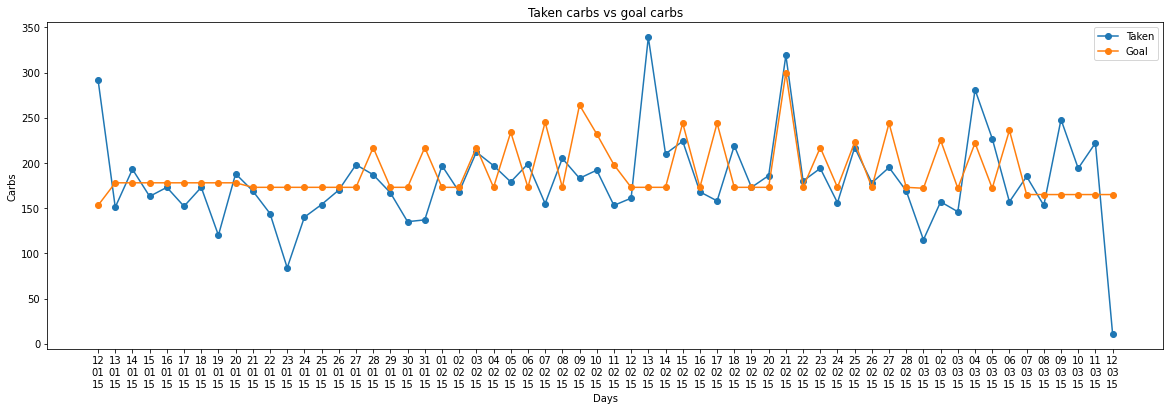

Average fat per day: 42.28333333333333


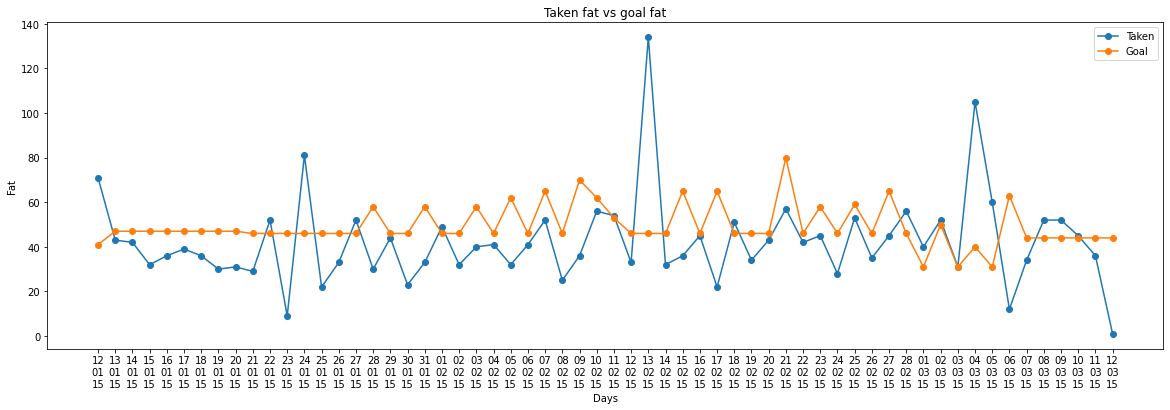

Average protein per day: 42.5


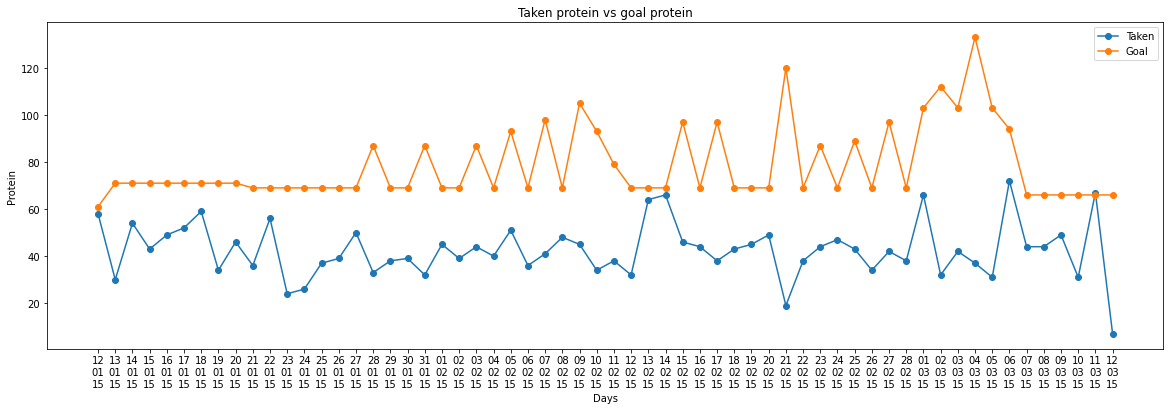

In [32]:
if len(sample_user["carbs"]) == 0:
    if len(sample_user["sugar"]) == 0:
        print("Average carbs per day: 0")
    else:
        print("Average carbs per day:", stats.mean(sample_user["sugar"].values()))
    plot_nutrients("sugar", "Sugar")
else:
    print("Average carbs per day:", stats.mean(sample_user["carbs"].values()))
    plot_nutrients("carbs", "Carbs")

if len(sample_user["fat"]) == 0:
    print("Average fat per day: 0")
else:
    print("Average fat per day:", stats.mean(sample_user["fat"].values()))
plot_nutrients("fat", "Fat")

if len(sample_user["fat"]) == 0:
    print("Average protein per day: 0")
else:
    print("Average protein per day:", stats.mean(sample_user["protein"].values()))

plot_nutrients("protein", "Protein")


In [33]:
print("First month and cumulative consumed calories:", sample_user["first_month"])
print("Last month and cumulative consumed calories:", sample_user["last_month"])

First month and cumulative consumed calories: {'date': '01/2015', 'days': 20, 'calories': 27445}
Last month and cumulative consumed calories: {'date': '03/2015', 'days': 12, 'calories': 16641}


## Insert prepared data to a pandas dataframe for further ML analysis

In [77]:
final_dict = {}
final_dict["user_activity"] = []
final_dict["average_calories_per_day"] = []
final_dict["average_carbs_per_day"] = []
final_dict["average_fat_per_day"] = []
final_dict["average_protein_per_day"] = []

Only taking what portion of food's energetic value these macronutrients make 
describes user's favourite food's nature more and is not likely to cause
unnecessary differentiation between users
In my opinion, this may be a problem when taking raw nutrients instead. Also, we thought that to compare we won't use weight metrics, because it might be a little bit (or not more) inaccurate. Instead we will use percentages to compare.

In [78]:
final_dict["favourite_food_carbs_part"] = []
final_dict["favourite_food_fat_part"] = []
final_dict["favourite_food_protein_part"] = []

goal_taken_calories_error: Taking taken and goal error of other nutrients may be better than including favourite food, but we'll try this for now. This will help us to track how user actually pursues his/her goals.

overal_calories_consumption_change: user's last active month average divided by first active month average. In some cases this might be a little bit misleading (for example, if in either month's activity was only several days; But we thought that it was best option).

In [79]:
# Taking taken and goal error of other nutrients may be better than
# including favourite food, but we'll try this for now
final_dict["goal_taken_calories_error"] = []
final_dict["overal_calories_consumption_change"] = []

In [80]:
def mean_root_squared_error(list_a, list_b):
    summation = 0
    n = len(list_a)
    for i in range (0, n):
      difference = list_a[i] - list_b[i]
      squared_difference = difference**2
      summation = summation + squared_difference
    return np.sqrt(summation/n)

In [81]:
keys = [key for key in altered_data.keys()]
for i in range(len(keys)):
    current_user = altered_data[keys[i]]

    # Dismissing users with at most month-long activity
    if current_user["active_days"] < 30 or current_user["first_month"]["date"] == current_user["last_month"]["date"]:
        continue
    food = current_user["food"]

    calculate_days(current_user)
    final_dict["user_activity"].append(current_user["active_days"] / current_user["days"])


    final_dict["average_calories_per_day"].append(stats.mean(current_user["calories"].values()))
    if len(current_user["carbs"]) == 0 and len(current_user["sugar"]) != 0:
        final_dict["average_carbs_per_day"].append(stats.mean(current_user["sugar"].values()))
    else:
        if len(current_user["carbs"]) == 0:
            final_dict["average_carbs_per_day"].append(0)
        else:
            final_dict["average_carbs_per_day"].append(stats.mean(current_user["carbs"].values()))
    
    if len(current_user["fat"]) == 0:
        final_dict["average_fat_per_day"].append(0)
    else:
        final_dict["average_fat_per_day"].append(stats.mean(current_user["fat"].values()))
    
    if len(current_user["protein"]) == 0:
        final_dict["average_protein_per_day"].append(0)
    else:
        final_dict["average_protein_per_day"].append(stats.mean(current_user["protein"].values()))

    fav_food = [key for key in food.keys()]
    fav_food.sort(key=food_sort)
    fav_food = food[fav_food[0]]
    fav_carbs = None
    fav_sugar = None
    fav_fat = None
    fav_proteins = None
    for nutrient in fav_food["nutrients"]:
        if nutrient["name"] == "Carbs":
            fav_carbs = int(nutrient["value"])
        if nutrient["name"] == "Sugar":
            fav_sugar = int(nutrient["value"])
        if nutrient["name"] == "Fat":
            fav_fat = int(nutrient["value"])
        if nutrient["name"] == "Protein":
            fav_proteins = int(nutrient["value"])
    if fav_carbs == None:
        if fav_sugar != None:
            fav_carbs = fav_sugar
        else:
            fav_carbs = 0
    if fav_fat == None:
        fav_fat = 0
    if fav_proteins == None:
        fav_proteins = 0
    fav_sum = fav_carbs + fav_fat + fav_proteins
    if fav_sum == 0:
        fav_sum = 1
    final_dict["favourite_food_carbs_part"].append(fav_carbs / fav_sum)
    final_dict["favourite_food_fat_part"].append(fav_fat / fav_sum)
    final_dict["favourite_food_protein_part"].append(fav_proteins / fav_sum)

    calories = [value for value in current_user["calories"].values()]
    goal_calories = [value for value in current_user["goal_calories"].values()]
    # We're taking root mean squared error instead of just mean squared error, as root will be less strict
    # in differentiating data and we will get a more uniform distribution. This will help us avoid unnecesary
    # grouping of mixed data when clustering.
    
    np.seterr(all='raise')
    
    try:
        final_dict["goal_taken_calories_error"].append(mean_root_squared_error(goal_calories, calories))
    except FloatingPointError:
        print(len(goal_calories), goal_calories)
        print(len(calories), calories)
        print("<--", mean_squared_error(goal_calories, calories, squared=True))
        print(mean_squared_error(goal_calories, calories, squared=False))
        print(final_dict["goal_taken_calories_error"][len(final_dict["goal_taken_calories_error"]) - 1], "-->")

    first_avg_cal = current_user["first_month"]["calories"] / current_user["first_month"]["days"]
    last_avg_cal = current_user["last_month"]["calories"] / current_user["last_month"]["days"]
    final_dict["overal_calories_consumption_change"].append(last_avg_cal / first_avg_cal)

final_data = pd.DataFrame(final_dict)
final_data.head()

,user_activity,average_calories_per_day,average_carbs_per_day,average_fat_per_day,average_protein_per_day,favourite_food_carbs_part,favourite_food_fat_part,favourite_food_protein_part,goal_taken_calories_error,overal_calories_consumption_change
0,0.966667,2308.908046,185.431034,77.942529,128.781609,0.391892,0.324324,0.283784,552.482626,1.119999
1,1.000000,1457.166667,181.200000,42.283333,42.500000,0.607143,0.035714,0.357143,462.270177,1.010567
2,1.000000,2997.938547,121.268156,77.195531,188.379888,0.478261,0.130435,0.391304,538.892725,0.930052
3,0.646067,1357.026087,141.295652,54.495652,67.347826,0.000000,0.000000,1.000000,471.969343,1.345699
4,0.480226,1975.200000,0.000000,0.000000,128.600000,0.000000,0.000000,1.000000,411.301478,0.426522


**Correlation matrix**

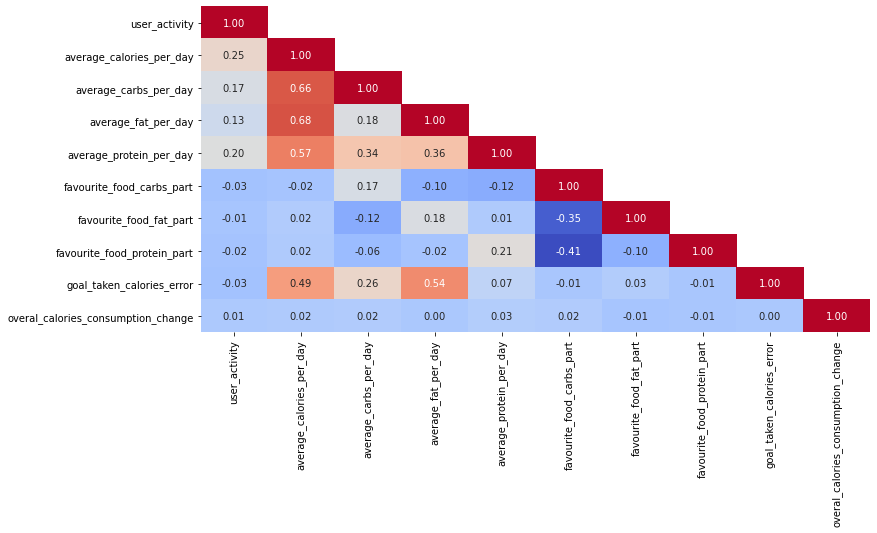

In [82]:
corr_matrix = final_data.corr()
f, ax = plt.subplots(figsize=(12, 6))
with sb.axes_style("white"):
    sb.heatmap(corr_matrix,mask=np.triu(corr_matrix,1),annot=True,fmt=".2f", vmax=.8,cbar=False,cmap="coolwarm");

# Clustering

**Scaling**

Scaling data using sklearn library

In [83]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(final_data)
pd.DataFrame(scaled_data).describe()

,0,1,2,3,4,5,6,7,8,9
count,5.823000e+03,5.823000e+03,5.823000e+03,5.823000e+03,5.823000e+03,5.823000e+03,5.823000e+03,5.823000e+03,5.823000e+03,5.823000e+03
mean,9.696100e-17,4.009615e-17,5.775143e-17,-9.662734e-17,7.119308e-17,-4.964830e-17,2.394330e-16,-9.498765e-17,-2.240752e-17,-2.508750e-17
std,1.000086e+00,1.000086e+00,1.000086e+00,1.000086e+00,1.000086e+00,1.000086e+00,1.000086e+00,1.000086e+00,1.000086e+00,1.000086e+00
min,-1.816097e+00,-2.447257e+00,-2.120053e+00,-1.644895e+00,-2.073509e+00,-1.066419e+00,-6.384333e-01,-8.275168e-01,-3.112783e-01,-5.621626e-02
25%,-8.962825e-01,-5.719936e-01,-5.134949e-01,-4.271939e-01,-5.759274e-01,-1.066419e+00,-6.384333e-01,-8.275168e-01,-1.224476e-01,-3.113962e-02
50%,-2.502189e-02,-1.222154e-01,-1.913380e-02,-7.849361e-02,-1.746288e-01,-6.402749e-02,-5.793906e-01,-4.158702e-01,-5.511275e-02,-2.507093e-02
75%,1.007386e+00,4.364276e-01,4.779793e-01,3.379710e-01,3.869235e-01,9.644002e-01,2.914896e-01,5.157511e-01,3.781638e-02,-1.805608e-02
max,1.368784e+00,2.864087e+01,3.725916e+01,4.993560e+01,2.328413e+01,1.511159e+00,3.081258e+00,2.362744e+00,5.886728e+01,7.408856e+01


Rational number of clusters should be between 2 to 10 by considering data's context interpretation possibilities as well as ease of handling afterwards 

**Inferring appropriate number of clusters using elbow method**

Storing sum of squared errors for each iteration for 2 to 10 clusters

In [84]:
sse = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters = k, init = 'k-means++', n_init = 20, max_iter = 300, tol = 0.0001, 
                    random_state = None, copy_x = True, algorithm = 'full').fit(scaled_data)
    sse.append(kmeans.inertia_)

Plotting sums of squared errors

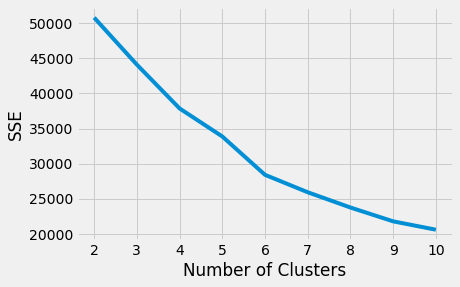

In [85]:
plt.style.use('fivethirtyeight')
plt.plot(range(2, 11), sse)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

Elbow doesn't make it very clear but, most of all, 6 seems to be the best number of clusters for our data

**Inferring appropriate number of clusters according to silhouette coefficients**

Storing silhouette coefficients for each iteration for 2 to 10 clusters

In [86]:
silhouette_coefficients = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters = k, init = 'k-means++', n_init = 20, max_iter = 300, tol = 0.0001, 
                    random_state = None, copy_x = True, algorithm = 'full').fit(scaled_data)
    score = silhouette_score(scaled_data, kmeans.labels_)
    silhouette_coefficients.append(score)

Plotting silhouette coefficient distribution

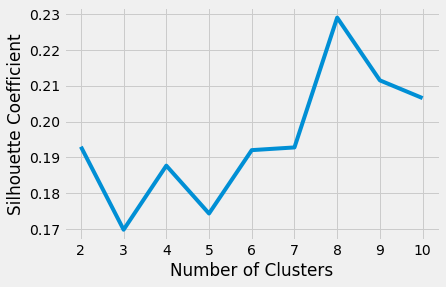

In [87]:
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

Silhouette coefficient method shows more comprehensible data and clearly 8 is the winner for number of clusters

**Both results still somewhat agree, but we choose 8 as a more clear candidate for the number of clusters**

## Final run of kmeans to store correct clusters

In [88]:
kmeans = KMeans(n_clusters = 8, init = 'k-means++', n_init = 20, max_iter = 300, tol = 0.0001, 
                    random_state = None, copy_x = True, algorithm = 'full').fit(scaled_data)

## Let's try shrinking data to 2 dimensions for possible better visual comprehension of clusters

In [89]:
reduced_data = PCA(n_components=2).fit_transform(scaled_data)

**Plotting dimension reduced data**

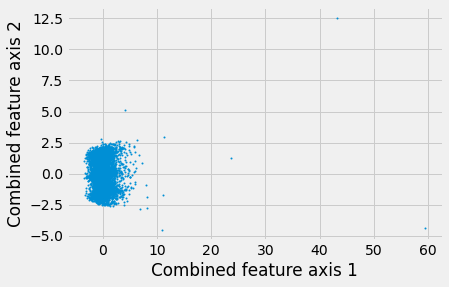

In [90]:
reduced_data_x = reduced_data[:, 0]
reduced_data_y = reduced_data[:, 1]
plt.scatter(reduced_data_x, reduced_data_y, marker='o', s=1, linewidths=1)
plt.xlabel("Combined feature axis 1")
plt.ylabel("Combined feature axis 2")
plt.show()

**Showing result clusters on reduced dimensions is not going to be useful as no distinguishable clusters are visible to naked eyes**

## Analysing each cluster

In [91]:
corresponding_clusters = kmeans.predict(scaled_data).tolist()
final_data['cluster'] = corresponding_clusters
final_data.head()

,user_activity,average_calories_per_day,average_carbs_per_day,average_fat_per_day,average_protein_per_day,favourite_food_carbs_part,favourite_food_fat_part,favourite_food_protein_part,goal_taken_calories_error,overal_calories_consumption_change,cluster
0,0.966667,2308.908046,185.431034,77.942529,128.781609,0.391892,0.324324,0.283784,552.482626,1.119999,0
1,1.000000,1457.166667,181.200000,42.283333,42.500000,0.607143,0.035714,0.357143,462.270177,1.010567,1
2,1.000000,2997.938547,121.268156,77.195531,188.379888,0.478261,0.130435,0.391304,538.892725,0.930052,0
3,0.646067,1357.026087,141.295652,54.495652,67.347826,0.000000,0.000000,1.000000,471.969343,1.345699,3
4,0.480226,1975.200000,0.000000,0.000000,128.600000,0.000000,0.000000,1.000000,411.301478,0.426522,3


In [100]:
clusters = []
for i in range(8):
    clusters.append(final_data.loc[final_data['cluster'] == i])
    del clusters[i]['cluster']

**First cluster description**

In [101]:
clusters[0].describe()

,user_activity,average_calories_per_day,average_carbs_per_day,average_fat_per_day,average_protein_per_day,favourite_food_carbs_part,favourite_food_fat_part,favourite_food_protein_part,goal_taken_calories_error,overal_calories_consumption_change
count,881.000000,881.000000,881.000000,881.000000,881.000000,881.000000,881.000000,881.000000,881.000000,881.000000
mean,0.817379,2031.857165,210.152783,75.293133,112.206959,0.498241,0.132393,0.228616,855.715711,1.151301
std,0.218234,422.767856,60.856462,29.820640,49.683918,0.360480,0.198034,0.247495,1880.777113,2.389089
min,0.173184,1329.642458,26.357143,0.000000,0.000000,0.000000,0.000000,0.000000,99.792730,0.008209
25%,0.683616,1763.988764,176.301587,60.938547,82.574468,0.103448,0.000000,0.000000,472.522342,0.843262
50%,0.922222,1933.865079,203.720670,70.925170,101.190184,0.500000,0.035714,0.166667,639.039162,0.987629
75%,1.000000,2177.440678,238.168831,84.195652,131.609589,0.828571,0.200000,0.363636,885.789028,1.118945
max,1.000000,5925.988950,664.779006,530.571429,875.837838,1.000000,1.000000,1.000000,41309.036216,66.595787


**Second cluster description**

In [102]:
clusters[1].describe()

,user_activity,average_calories_per_day,average_carbs_per_day,average_fat_per_day,average_protein_per_day,favourite_food_carbs_part,favourite_food_fat_part,favourite_food_protein_part,goal_taken_calories_error,overal_calories_consumption_change
count,2263.000000,2263.000000,2263.000000,2263.000000,2263.000000,2263.000000,2263.000000,2263.000000,2263.000000,2263.000000
mean,0.586105,1226.190513,135.613397,42.122677,58.554574,0.787451,0.068442,0.144107,695.006212,1.497207
std,0.253041,280.407552,39.180952,15.266802,20.164726,0.190505,0.097660,0.152547,316.509605,9.836154
min,0.163043,215.100000,6.830189,0.000000,0.000000,0.266667,0.000000,0.000000,81.569201,0.013189
25%,0.367524,1052.068353,110.642977,33.662482,46.683333,0.625000,0.000000,0.000000,497.272548,0.744671
50%,0.547619,1244.875676,137.285714,43.000000,57.610169,0.808511,0.000000,0.083333,636.531159,0.954903
75%,0.809119,1416.307580,161.254295,51.432959,69.804276,0.966667,0.120976,0.250000,827.209281,1.203787
max,1.000000,3156.395833,296.706667,117.250000,138.552239,1.000000,0.428571,0.611111,5570.743499,428.200000


**Third cluster description**

In [103]:
clusters[2].describe()

,user_activity,average_calories_per_day,average_carbs_per_day,average_fat_per_day,average_protein_per_day,favourite_food_carbs_part,favourite_food_fat_part,favourite_food_protein_part,goal_taken_calories_error,overal_calories_consumption_change
count,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000
mean,0.609696,1286.395105,112.501038,56.598390,66.962708,0.113596,0.649080,0.237325,686.450330,1.201206
std,0.260388,316.669297,50.733152,22.079298,23.548228,0.141928,0.237224,0.217130,326.514111,2.191198
min,0.175439,240.500000,0.000000,1.094340,0.000000,0.000000,0.250000,0.000000,157.792167,0.027152
25%,0.379888,1085.739726,76.566265,41.948718,51.975000,0.000000,0.454545,0.000000,478.196821,0.763017
50%,0.581006,1269.382353,116.701754,52.547297,64.548387,0.043478,0.571429,0.200000,626.749607,0.963268
75%,0.860335,1491.965909,148.562092,66.833333,79.205128,0.200000,1.000000,0.464286,826.789375,1.187294
max,1.000000,2976.434783,257.124260,178.784946,172.701087,0.545455,1.000000,0.625000,3770.777786,41.352174


**Fourth cluster description**

In [104]:
clusters[3].describe()

,user_activity,average_calories_per_day,average_carbs_per_day,average_fat_per_day,average_protein_per_day,favourite_food_carbs_part,favourite_food_fat_part,favourite_food_protein_part,goal_taken_calories_error,overal_calories_consumption_change
count,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000
mean,0.631554,1332.265083,123.908661,46.800224,80.842520,0.079917,0.056897,0.863185,701.821021,1.531743
std,0.258858,328.567749,49.833078,19.544376,30.941425,0.126550,0.093651,0.161182,295.784447,10.256342
min,0.167598,300.112360,0.000000,0.000000,18.800000,0.000000,0.000000,0.416667,72.837452,0.060004
25%,0.407794,1107.786254,92.998270,36.335351,58.547711,0.000000,0.000000,0.750000,494.351627,0.807566
50%,0.610778,1333.495726,127.206704,46.647727,75.787671,0.000000,0.000000,0.921053,645.713246,0.987011
75%,0.891111,1546.600000,155.421379,57.941406,97.098853,0.131579,0.076923,1.000000,841.727391,1.200007
max,1.000000,2968.177778,298.985714,137.132812,293.805556,0.500000,0.416667,1.000000,2077.086830,298.402778


**Fifth cluster description**

In [105]:
clusters[4].describe()

,user_activity,average_calories_per_day,average_carbs_per_day,average_fat_per_day,average_protein_per_day,favourite_food_carbs_part,favourite_food_fat_part,favourite_food_protein_part,goal_taken_calories_error,overal_calories_consumption_change
count,1.0,1.000000,1.000000,1.000000,1.00,1.0,1.0,1.0,1.000000,1.000000
mean,1.0,2186.994444,266.577778,62.566667,146.95,1.0,0.0,0.0,820.232294,2300.642857
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.0,2186.994444,266.577778,62.566667,146.95,1.0,0.0,0.0,820.232294,2300.642857
25%,1.0,2186.994444,266.577778,62.566667,146.95,1.0,0.0,0.0,820.232294,2300.642857
50%,1.0,2186.994444,266.577778,62.566667,146.95,1.0,0.0,0.0,820.232294,2300.642857
75%,1.0,2186.994444,266.577778,62.566667,146.95,1.0,0.0,0.0,820.232294,2300.642857
max,1.0,2186.994444,266.577778,62.566667,146.95,1.0,0.0,0.0,820.232294,2300.642857


**Sixth cluster description**

In [106]:
clusters[5].describe()

,user_activity,average_calories_per_day,average_carbs_per_day,average_fat_per_day,average_protein_per_day,favourite_food_carbs_part,favourite_food_fat_part,favourite_food_protein_part,goal_taken_calories_error,overal_calories_consumption_change
count,780.000000,780.000000,780.000000,780.000000,780.000000,780.0,780.0,780.0,780.000000,780.000000
mean,0.647918,1261.960751,120.352082,45.851380,59.543298,0.0,0.0,0.0,699.846099,1.145104
std,0.258654,284.721963,49.927734,20.087639,21.803077,0.0,0.0,0.0,312.229660,1.638561
min,0.173184,219.796117,0.000000,0.000000,0.000000,0.0,0.0,0.0,75.168179,0.000000
25%,0.408792,1069.147727,90.110983,36.376605,48.370871,0.0,0.0,0.0,486.807710,0.773532
50%,0.656415,1263.199738,127.581924,46.189617,59.386804,0.0,0.0,0.0,630.937406,0.950904
75%,0.896615,1465.464244,155.069891,55.987705,71.048780,0.0,0.0,0.0,849.739761,1.186358
max,1.000000,2438.683333,246.590909,138.626374,139.677419,0.0,0.0,0.0,2456.660553,41.057143


**Seventh cluster description**

In [107]:
clusters[6].describe()

,user_activity,average_calories_per_day,average_carbs_per_day,average_fat_per_day,average_protein_per_day,favourite_food_carbs_part,favourite_food_fat_part,favourite_food_protein_part,goal_taken_calories_error,overal_calories_consumption_change
count,1.00000,1.0,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.000000,1.000000
mean,0.52795,15056.6,65.952941,1605.552941,35.964706,0.0,1.0,0.0,130105.777837,1.641655
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,0.52795,15056.6,65.952941,1605.552941,35.964706,0.0,1.0,0.0,130105.777837,1.641655
25%,0.52795,15056.6,65.952941,1605.552941,35.964706,0.0,1.0,0.0,130105.777837,1.641655
50%,0.52795,15056.6,65.952941,1605.552941,35.964706,0.0,1.0,0.0,130105.777837,1.641655
75%,0.52795,15056.6,65.952941,1605.552941,35.964706,0.0,1.0,0.0,130105.777837,1.641655
max,0.52795,15056.6,65.952941,1605.552941,35.964706,0.0,1.0,0.0,130105.777837,1.641655


**Eighth cluster description**

In [108]:
clusters[7].describe()

,user_activity,average_calories_per_day,average_carbs_per_day,average_fat_per_day,average_protein_per_day,favourite_food_carbs_part,favourite_food_fat_part,favourite_food_protein_part,goal_taken_calories_error,overal_calories_consumption_change
count,1.00000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.00000,1.000000,1.000000
mean,0.49162,11121.465909,2589.681818,81.215909,267.318182,0.47619,0.206349,0.31746,88815.776913,0.564027
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,0.49162,11121.465909,2589.681818,81.215909,267.318182,0.47619,0.206349,0.31746,88815.776913,0.564027
25%,0.49162,11121.465909,2589.681818,81.215909,267.318182,0.47619,0.206349,0.31746,88815.776913,0.564027
50%,0.49162,11121.465909,2589.681818,81.215909,267.318182,0.47619,0.206349,0.31746,88815.776913,0.564027
75%,0.49162,11121.465909,2589.681818,81.215909,267.318182,0.47619,0.206349,0.31746,88815.776913,0.564027
max,0.49162,11121.465909,2589.681818,81.215909,267.318182,0.47619,0.206349,0.31746,88815.776913,0.564027


DESCRIPTION OF THESE CLUSTERS - INFERRING USER INFORMATION

We think there are possible ways of improving clustering results.

We tried not to overload data with variables, but we should still be able to add couple of variables without much complication and for a more meaningful clustering. Examples are MRSE-s of distributions of macronutrients and their goal counterparts as we did with calories. A user may be successful in hitting goal calories, while doing it with a wrong diet, so we think it's needed to consider macronutrient goal vs real intake performance.

CLUSTERING AGAIN AND JUDGING THE PERFORMANCE DIFFERENCE BY INFERRING USER INFORMATION FROM NEW CLUSTERS

# Recommendation System

Function below merges dictionaries and adds values of the same keys

In [ ]:
def merge_dict(dict1, dict2):
    dict3 = {**dict1, **dict2}
    for key, value in dict3.items():
        # more strict comparison may be needed which includes nutrition comparison
        # as the same product may be in different packages with different nutrtition info
        if key in dict1 and key in dict2:
            new_value = value
            new_value["count"] += dict1[key]["count"]
            dict3[key] = new_value
        return dict3

In [ ]:
food_analysis = {}

for user in altered_data:
    food_analysis = merge_dict(food_analysis, altered_data[user]["food"])
print(food_analysis)

Visualize food sorted according to its consumption frequency